In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging

import holoviews as hv
import hvplot.polars  # noqa
import neurokit2 as nk
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.features.transforming import merge_dfs
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG, ignore_libs=("Comm", "bokeh", "tornado", "matplotlib")
)
logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_table("Preprocess_eda")
df

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_raw,eda_tonic,eda_phasic
u16,u8,u8,u32,f64,i64,f64,f64,f64
1,1,1,37660,294210.3603,57892,0.752359,0.752113,0.000246
1,1,1,37661,294211.3575,57893,0.754579,0.752115,0.002464
1,1,1,37663,294224.331,57895,0.753247,0.752117,0.00113
1,1,1,37664,294242.275,57896,0.754135,0.752119,0.002016
1,1,1,37666,294248.2588,57898,0.754135,0.752121,0.002014
1,1,1,37667,294276.1835,57899,0.754135,0.752123,0.002012
…,…,…,…,…,…,…,…,…
332,12,28,355476,2.7771e6,467073,13.679468,13.578894,-0.012187
332,12,28,355477,2.7771e6,467074,13.679468,13.578894,-0.012765


## Comparing neurokit / biopac / highpass filter (0.05 Hz) vs Median smoothing

From the neurokit2 documentation:
  * **High-pass filtering**: Method implemented in Biopac's Acqknowledge. The raw EDA signal
    is passed through a high pass filter with a cutoff frequency of 0.05 Hz
    (cutoff frequency can be adjusted by the ``cutoff`` argument).
  * **Median smoothing**: Method implemented in Biopac's Acqknowledge. The raw EDA signal is
    passed through a median value smoothing filter, which removes areas of rapid change. The
    phasic component is then calculated by subtracting the smoothed signal from the original.
    This method is computationally intensive and the processing time depends on the smoothing
    factor, which can be controlled by the as ``smoothing_factor`` argument, set by default to
    ``4`` seconds. Higher values will produce results more rapidly.

In [5]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=["eda_raw", "eda_phasic", "eda_tonic"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a7fcd346-552f-4886-9c48-c1a8b034fa7a': {'version…

In [6]:
from matplotlib import pyplot as plt

da = df.filter(col("trial_id") == 5).get_column("eda_tonic").to_numpy()
da

array([0.80774171, 0.80774181, 0.8077419 , ..., 0.79725289, 0.79725289,
       0.79725289])

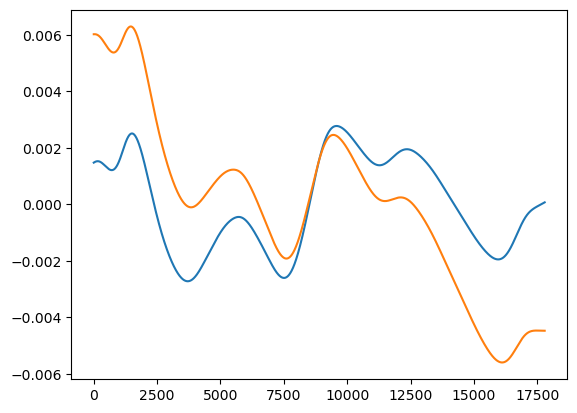

In [7]:
from scipy.signal import detrend

# plt.plot(da)
plt.plot(detrend(da))
plt.plot(detrend(da, type="constant"))


In [26]:
from src.features.transforming import map_trials


@map_trials
def detrend_tonic_component(
    df: pl.DataFrame,
) -> pl.DataFrame:
    return df.with_columns(
        col("eda_tonic")
        .map_batches(
            lambda x: detrend(
                x.to_numpy(),
            )
        )
        .name.suffix("_detrended")
    )


df = detrend_tonic_component(df)
df

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended
u16,u8,u8,u32,f64,i64,f64,f64,f64,f64
1,1,1,37660,294210.3603,57892,0.752359,0.752113,0.000246,-0.000092
1,1,1,37661,294211.3575,57893,0.754579,0.752115,0.002464,-0.00009
1,1,1,37663,294224.331,57895,0.753247,0.752117,0.00113,-0.000088
1,1,1,37664,294242.275,57896,0.754135,0.752119,0.002016,-0.000086
1,1,1,37666,294248.2588,57898,0.754135,0.752121,0.002014,-0.000084
1,1,1,37667,294276.1835,57899,0.754135,0.752123,0.002012,-0.000082
…,…,…,…,…,…,…,…,…,…
332,12,28,355476,2.7771e6,467073,13.679468,13.578894,-0.012187,1.382276
332,12,28,355477,2.7771e6,467074,13.679468,13.578894,-0.012765,1.382664


In [27]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=["eda_raw", "eda_phasic", "eda_tonic", "eda_tonic_detrended"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ec86e271-44dc-4684-962f-7a995c4267c9': {'version…

In [31]:
with db:
    stimulus = db.get_table("Feature_stimulus")

merged = merge_dfs([df, stimulus])
scale_min_max(merged.interpolate()).hvplot(
    x="timestamp",
    y=["eda_tonic", "eda_tonic_detrended", "rating", "eda_raw"],
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'579cc90f-46b9-4877-8a61-b7073eac3605': {'version…

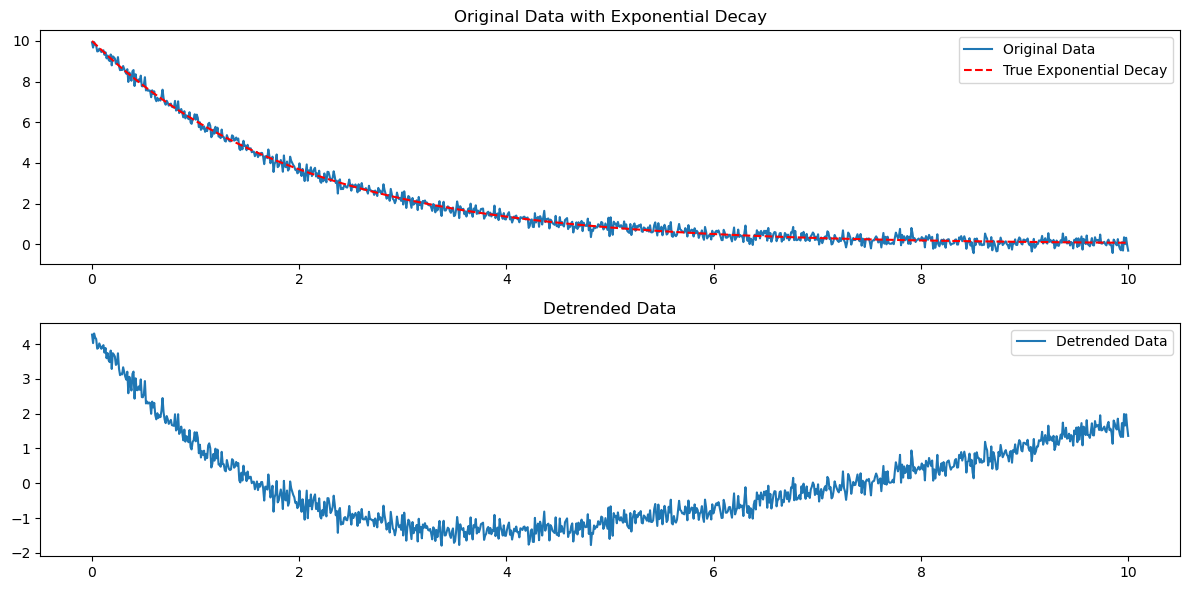

Mean of detrended data: 0.000000
Mean of original data: 1.986067


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


# Generate sample data
def generate_exponential_decay(t, amplitude, decay_rate, noise_level):
    decay = amplitude * np.exp(-decay_rate * t)
    noise = np.random.normal(0, noise_level, len(t))
    return decay + noise


# Set up parameters
t = np.linspace(0, 10, 1000)
amplitude = 10
decay_rate = 0.5
noise_level = 0.2

# Generate synthetic data
data = generate_exponential_decay(t, amplitude, decay_rate, noise_level)

# Detrend the data
detrended_data = signal.detrend(data)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, data, label="Original Data")
plt.plot(t, amplitude * np.exp(-decay_rate * t), "r--", label="True Exponential Decay")
plt.title("Original Data with Exponential Decay")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, detrended_data, label="Detrended Data")
plt.title("Detrended Data")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print the mean of the detrended data
print(f"Mean of detrended data: {np.mean(detrended_data):.6f}")
print(f"Mean of original data: {np.mean(data):.6f}")


In [33]:
from src.data.data_config import DataConfig

DataConfig.load_imotions_config()["PPG"]

{'file_name': 'Shimmer3_EDA_&_PPG_Shimmer3_EDA_&_PPG_ET_Shimmer_ShimmerDevice',
 'load_columns': ['RowNumber',
  'SampleNumber',
  'Timestamp',
  'Internal ADC A13 PPG CAL',
  'Heart Rate PPG ALG',
  'IBI PPG ALG'],
 'rename_columns': {'Internal ADC A13 PPG CAL': 'PPG_RAW',
  'Heart Rate PPG ALG': 'PPG_HeartRate',
  'IBI PPG ALG': 'PPG_IBI'}}